# SGS Analytical Methods

This notebook focuses on analytical methods and assumes you provide real input data (no synthetic fallbacks).


## Setup and User Data Paths

Provide file paths to your data files (GeoTIFF, GeoJSON, or GeoPackage). All paths used below are required.


In [1]:
# =============================================================================
# USER CONFIGURATION
# =============================================================================
DATA_CONFIG = {
    # Rasters
    "continuous_raster_path": 'data/raster/spectral/idx_clay_hydroxyls.tif',
    "categorical_raster_path": None,  # GeoTIFF with class labels

    # Vector data
    "vector_path": 'data/vector/lithology.geojson', 
    "geochem_points_path": 'data/vector/geochem.geojson', 

    # Raster data
    "spectral_indices_dir": 'data/raster/spectral', 
    "geophysics_dir": 'data/raster/geophys',  

    # Prospectivity mapping
    "prospectivity_feature_rasters": [],  # List of raster paths (GeoTIFF)
    "prospectivity_training_points_path": None,  # GeoJSON with known deposits
}



## Imports


In [2]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import rasterio
from rasterio.transform import from_bounds
from rasterio.features import rasterize

from scipy.ndimage import gaussian_filter
from scipy.spatial import KDTree
from scipy.spatial.distance import cdist

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')


## Load Helpers and Prepare Data


In [3]:
import sys
sys.path.append(str(Path.cwd()))
import helpers as h


def require_path(path, name, allow_dir=False):
    if not path:
        raise ValueError(f"Missing required path for {name}.")
    p = Path(path)
    if allow_dir:
        if not p.exists() or not p.is_dir():
            raise ValueError(f"{name} must be an existing directory: {path}")
    else:
        if not p.exists():
            raise ValueError(f"{name} must be an existing file: {path}")
    return p


# --- Continuous raster ---
continuous_path = require_path(DATA_CONFIG['continuous_raster_path'], 'continuous_raster_path')
continuous_raster, raster_extent, raster_crs = h.load_raster(continuous_path)

# --- Vector data (lithology) ---
vector_path = require_path(DATA_CONFIG['vector_path'], 'vector_path')
vector_gdf = h.load_vector(vector_path)

# --- Categorical raster (rasterized lithology) ---
if DATA_CONFIG['categorical_raster_path']:
    categorical_path = require_path(DATA_CONFIG['categorical_raster_path'], 'categorical_raster_path')
    categorical_raster, _, _ = h.load_raster(categorical_path)
else:
    categorical_raster = h.rasterize_lithology(vector_gdf, continuous_raster.shape, raster_extent)

# --- Geochemistry points ---
geochem_path = require_path(DATA_CONFIG['geochem_points_path'], 'geochem_points_path')
geochem_gdf = h.load_vector(geochem_path)
geochem_gdf = h.ensure_xy(geochem_gdf)

print('Raster shape:', continuous_raster.shape)
print('Vector records:', len(vector_gdf))
print('Geochem records:', len(geochem_gdf))


Raster shape: (351, 396)
Vector records: 463
Geochem records: 1243


## Analytical Methods


### Interpolation (IDW + Kriging)


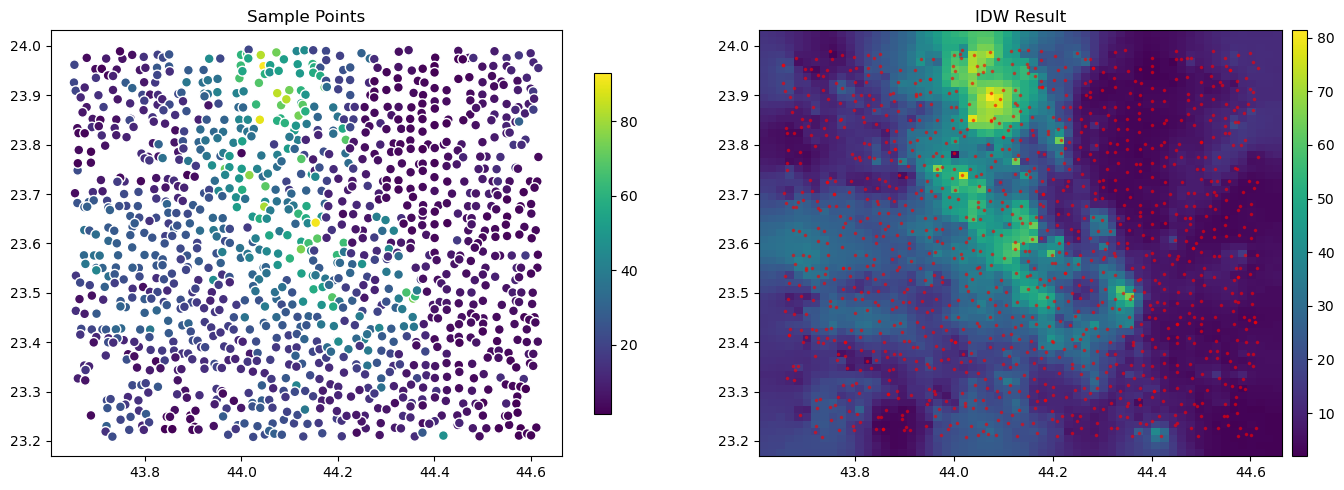

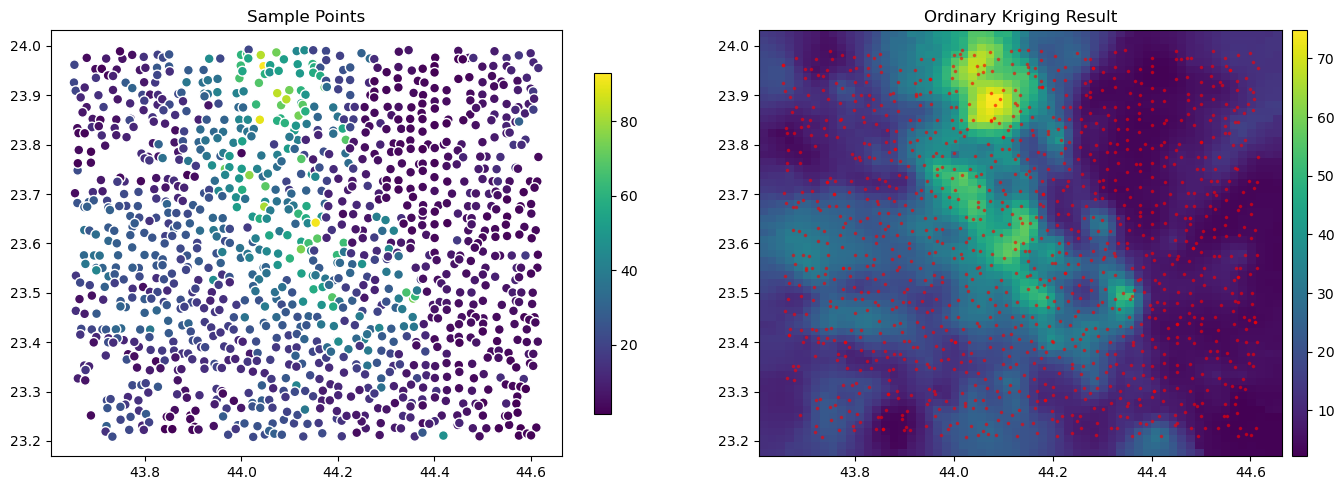

In [4]:
# Prepare sample points and grid
numeric_cols = geochem_gdf.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = {'X', 'Y', 'id', 'coord_x', 'coord_y', 'elevation_m'}
feature_cols = [c for c in numeric_cols if c not in exclude_cols]
if not feature_cols:
    raise ValueError('No numeric feature columns found in geochem data.')

cu_candidates = [c for c in numeric_cols if 'cu' in c.lower()]
value_col = cu_candidates[0] if cu_candidates else feature_cols[0]

sample_coords = geochem_gdf[['X', 'Y']].values
sample_values = geochem_gdf[value_col].values

xmin, xmax = sample_coords[:, 0].min(), sample_coords[:, 0].max()
ymin, ymax = sample_coords[:, 1].min(), sample_coords[:, 1].max()

# Add padding to avoid edge effects
pad_x = (xmax - xmin) * 0.05
pad_y = (ymax - ymin) * 0.05
interp_extent = (xmin - pad_x, xmax + pad_x, ymin - pad_y, ymax + pad_y)

xmin, xmax, ymin, ymax = interp_extent
grid_resolution = 60
x_grid = np.linspace(xmin, xmax, grid_resolution)
y_grid = np.linspace(ymin, ymax, grid_resolution)
xx, yy = np.meshgrid(x_grid, y_grid)
grid_points = np.column_stack([xx.ravel(), yy.ravel()])

# IDW interpolation
idw_pred = h.idw_interpolation(sample_coords, sample_values, grid_points, power=2)
idw_grid = idw_pred.reshape(grid_resolution, grid_resolution)

h.plot_interpolation_results(sample_coords, sample_values, idw_grid, interp_extent, method_name='IDW')
plt.show()

# Fit variogram (no plot)
lags, semivar = h.compute_semivariogram(sample_coords, sample_values)
nugget, sill, range_param = h.fit_variogram(lags, semivar)

kriging_pred, kriging_var = h.ordinary_kriging(
    sample_coords, sample_values, grid_points, nugget, sill, range_param, n_neighbors=12
)

kriging_grid = kriging_pred.reshape(grid_resolution, grid_resolution)

h.plot_interpolation_results(sample_coords, sample_values, kriging_grid, interp_extent, method_name='Ordinary Kriging')
plt.show()


### PCA


Original dimensions: 57


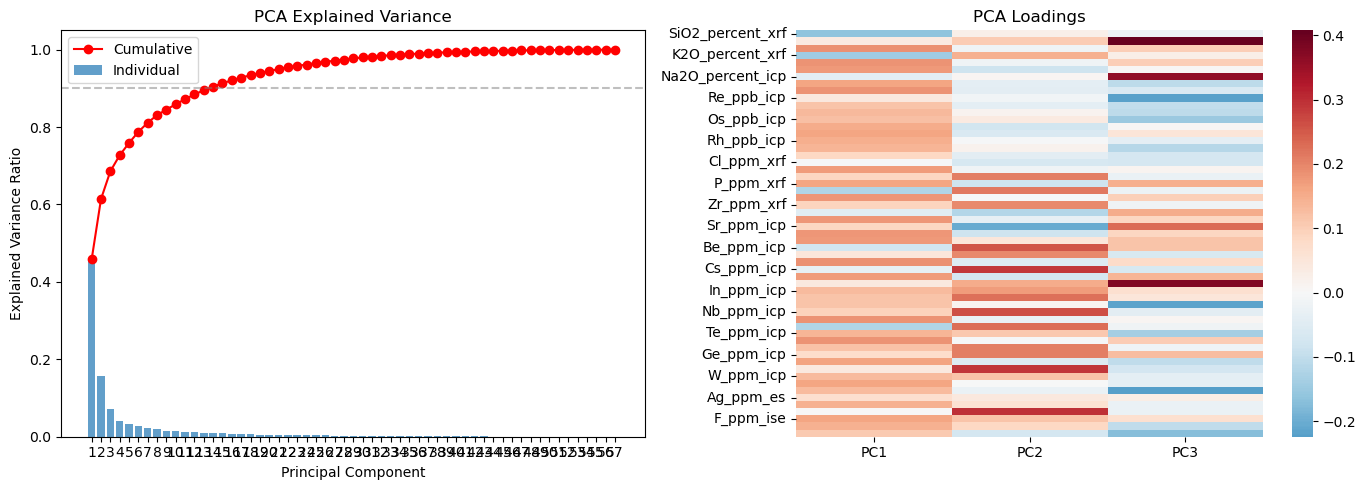

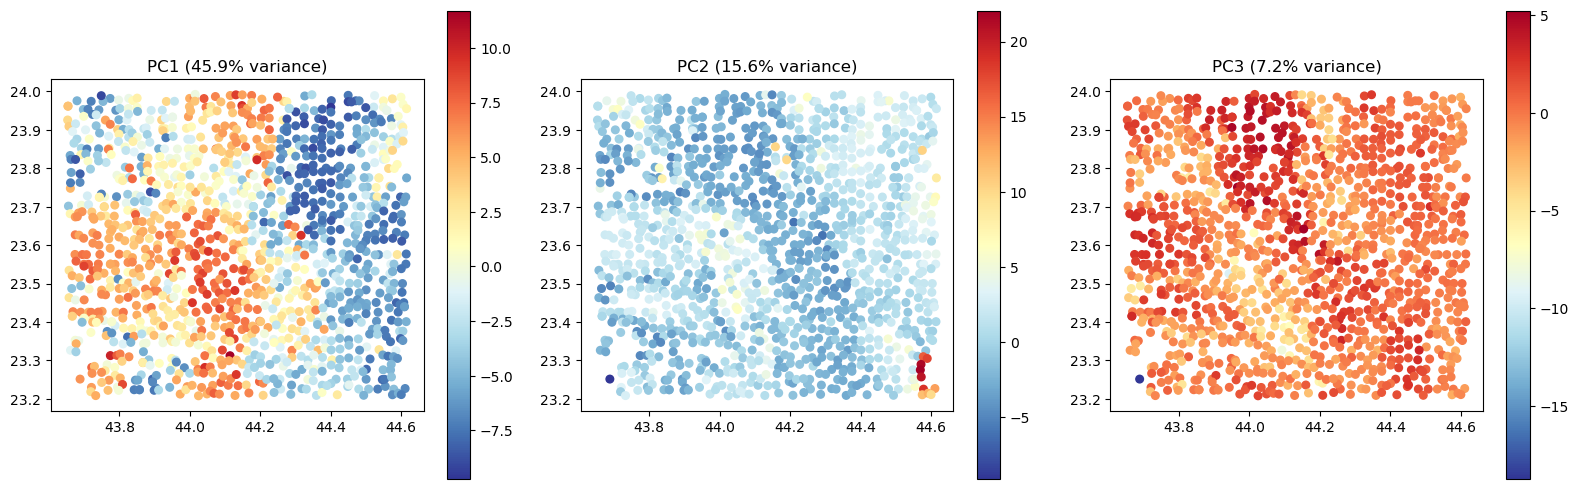

In [5]:
# Prepare data for PCA
pca_exclude = {'id', 'elevation_m'}
pca_cols = [c for c in feature_cols if c not in pca_exclude]

X_geochem = geochem_gdf[pca_cols].values

# Log transform (common for geochemical data)
X_log = np.log(X_geochem + 1)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

print(f"Original dimensions: {X_geochem.shape[1]}")

# Visualize PCA results
fig, axes = h.plot_pca_results(pca, pca_cols, figsize=(14, 5))
plt.show()


# Spatial visualization of principal components
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, ax in enumerate(axes):
    gdf_temp = geochem_gdf.copy()
    gdf_temp[f'PC{i+1}'] = X_pca[:, i]
    gdf_temp.plot(column=f'PC{i+1}', ax=ax, legend=True, cmap='RdYlBu_r', markersize=30)
    ax.set_title(f'PC{i+1} ({pca.explained_variance_ratio_[i]*100:.1f}% variance)')

plt.tight_layout()
plt.show()


### K-means (Geochemical Populations)


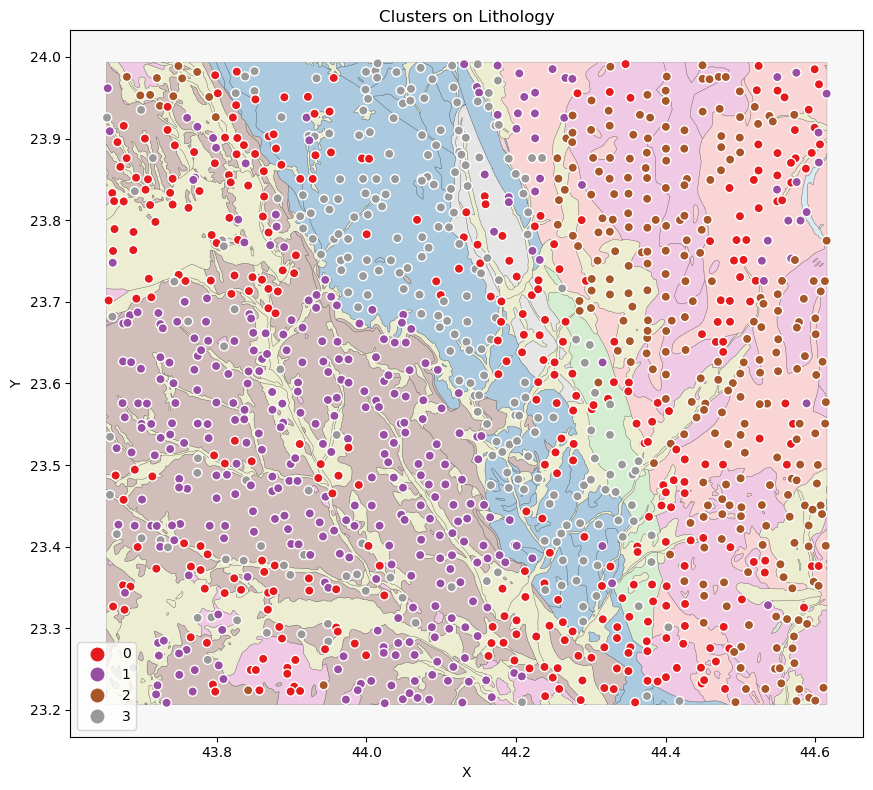

In [6]:
# Overlay clusters on lithology
fig, ax = plt.subplots(figsize=(10, 8))

lith_column = 'gross_lithology'
lith_column = 'geology_name'
lith_column = 'geological_period'
lith_column = 'tectonic_setting'


if lith_column in vector_gdf.columns:
    h.plot_vector(
        vector_gdf,
        column=lith_column,
        categorical=True,
        categorical_cmap='tab20',
        ax=ax,
        title='Clusters on Lithology',
        alpha=0.35,
        edgecolor='black',
        linewidth=0.3,
    )
else:
    vector_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.4)
    ax.set_title('Clusters on Lithology')

# Ensure clustering exists
if 'cluster_labels' not in globals():
    optimal_k = 4
    kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = kmeans_final.fit_predict(X_scaled)

# Cluster points with high contrast
gdf_clustered = geochem_gdf.copy()
gdf_clustered['cluster'] = cluster_labels

gdf_clustered.plot(
    column='cluster',
    ax=ax,
    legend=True,
    categorical=True,
    cmap='Set1',
    markersize=45,
    edgecolor='white',
    linewidth=1.0,
)

ax.set_facecolor('#f7f7f7')
plt.tight_layout()
plt.show()


### Multivariate Anomaly Detection (Isolation Forest)

See full reference implementation in `anomaly_detection/`.


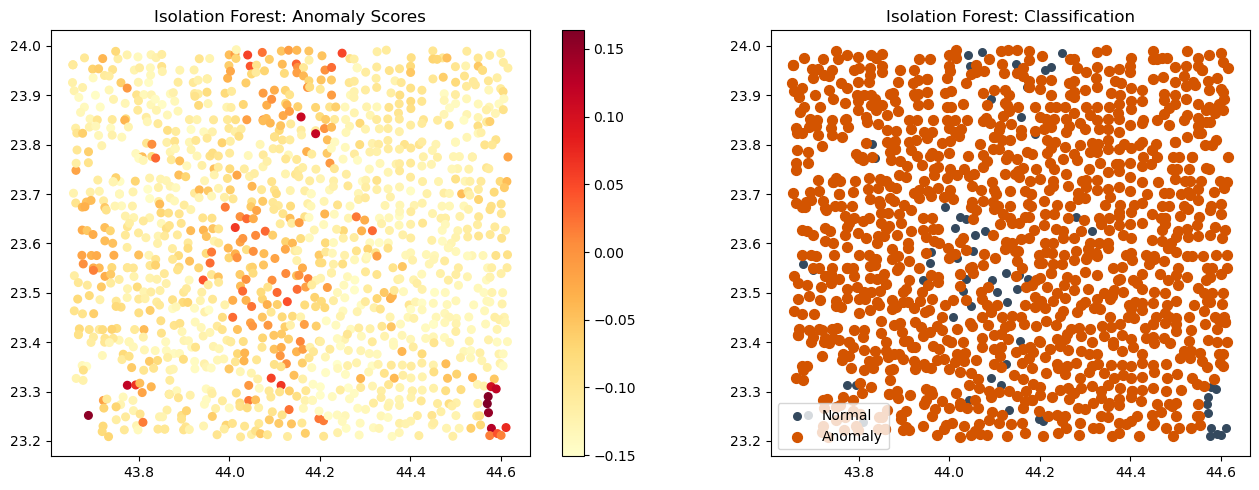

In [7]:
# Omit non-informative columns for anomaly detection
anom_exclude = {'id', 'coord_x', 'coord_y', 'elevation_m'}
anom_cols = [c for c in feature_cols if c not in anom_exclude]

# Use raw input features for anomaly detection
X_anom_scaled = geochem_gdf[anom_cols].values

iso = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
iso_labels = iso.fit_predict(X_anom_scaled)
scores = -iso.decision_function(X_anom_scaled)

h.plot_anomaly_scores(geochem_gdf, scores, binary_labels=iso_labels, title='Isolation Forest')
plt.show()


### Spectral Halo Classification

See full reference implementation in `MinersWork/spectral_unsupervised/spectral_unsupervised_class.ipynb`.


Use indices like clay/Al-OH, iron oxide (ferric), ferrous iron, silica, gossan, and laterite. Sentinel-2 does not provide a direct carbonate index, so these act as proxies.


Loaded 7 spectral indices


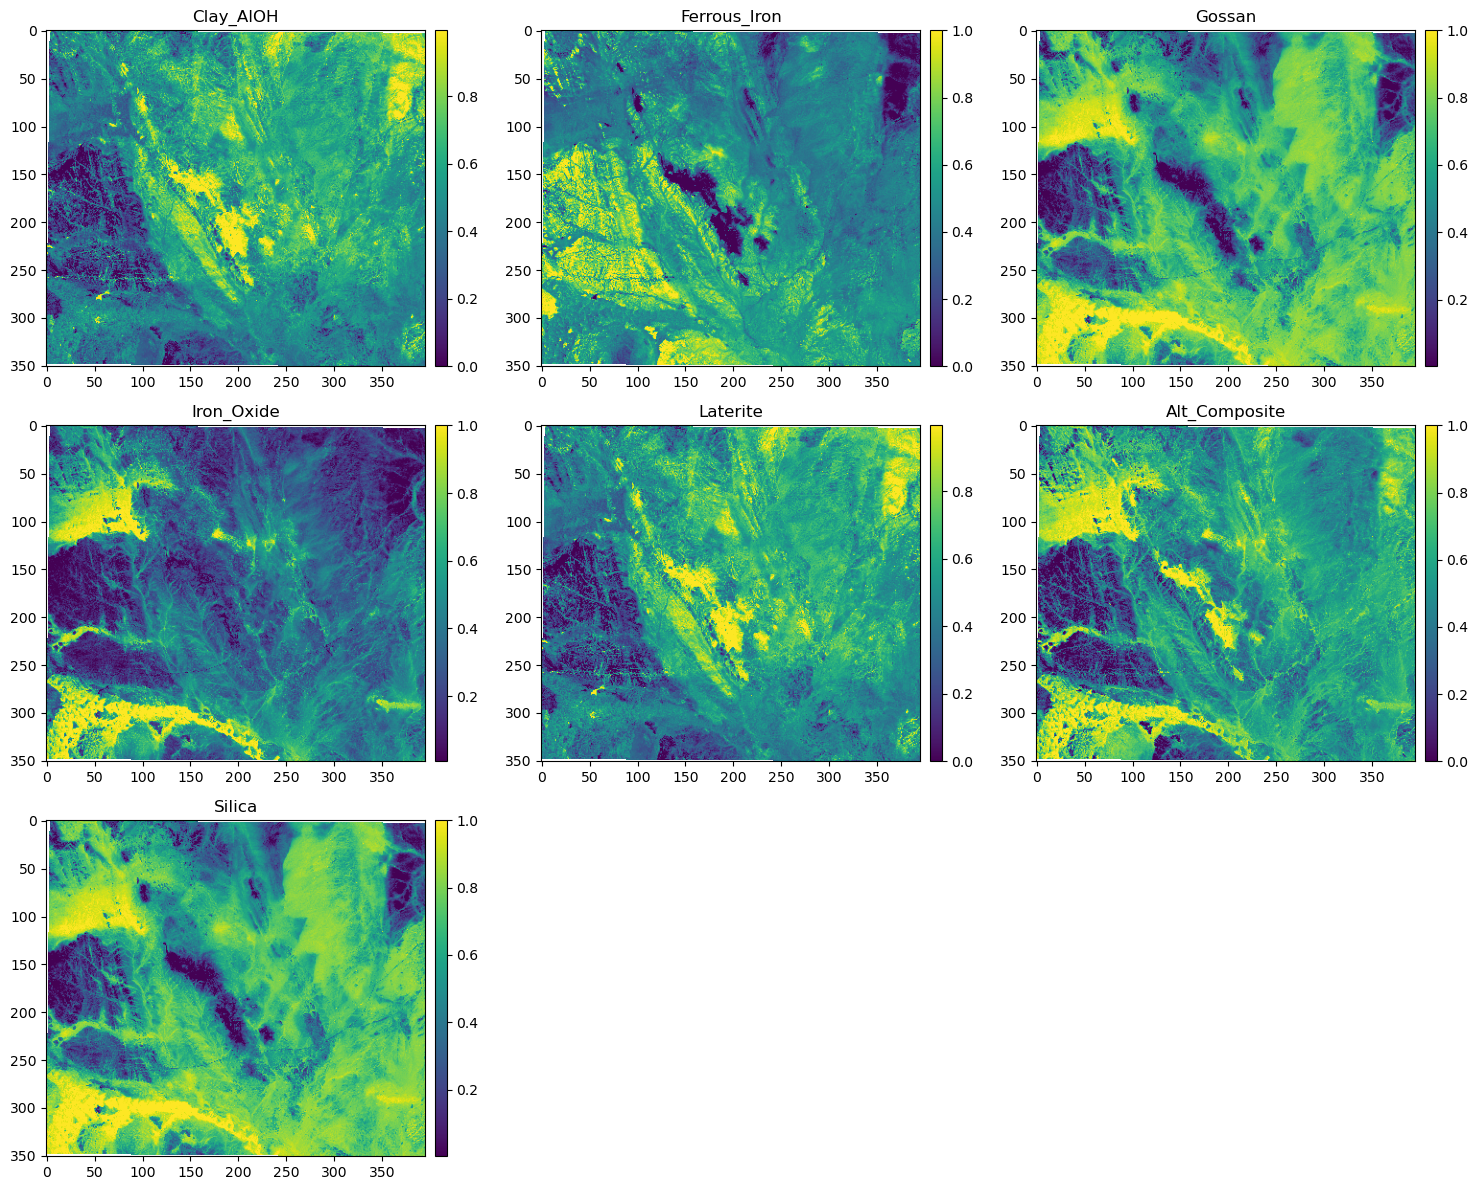

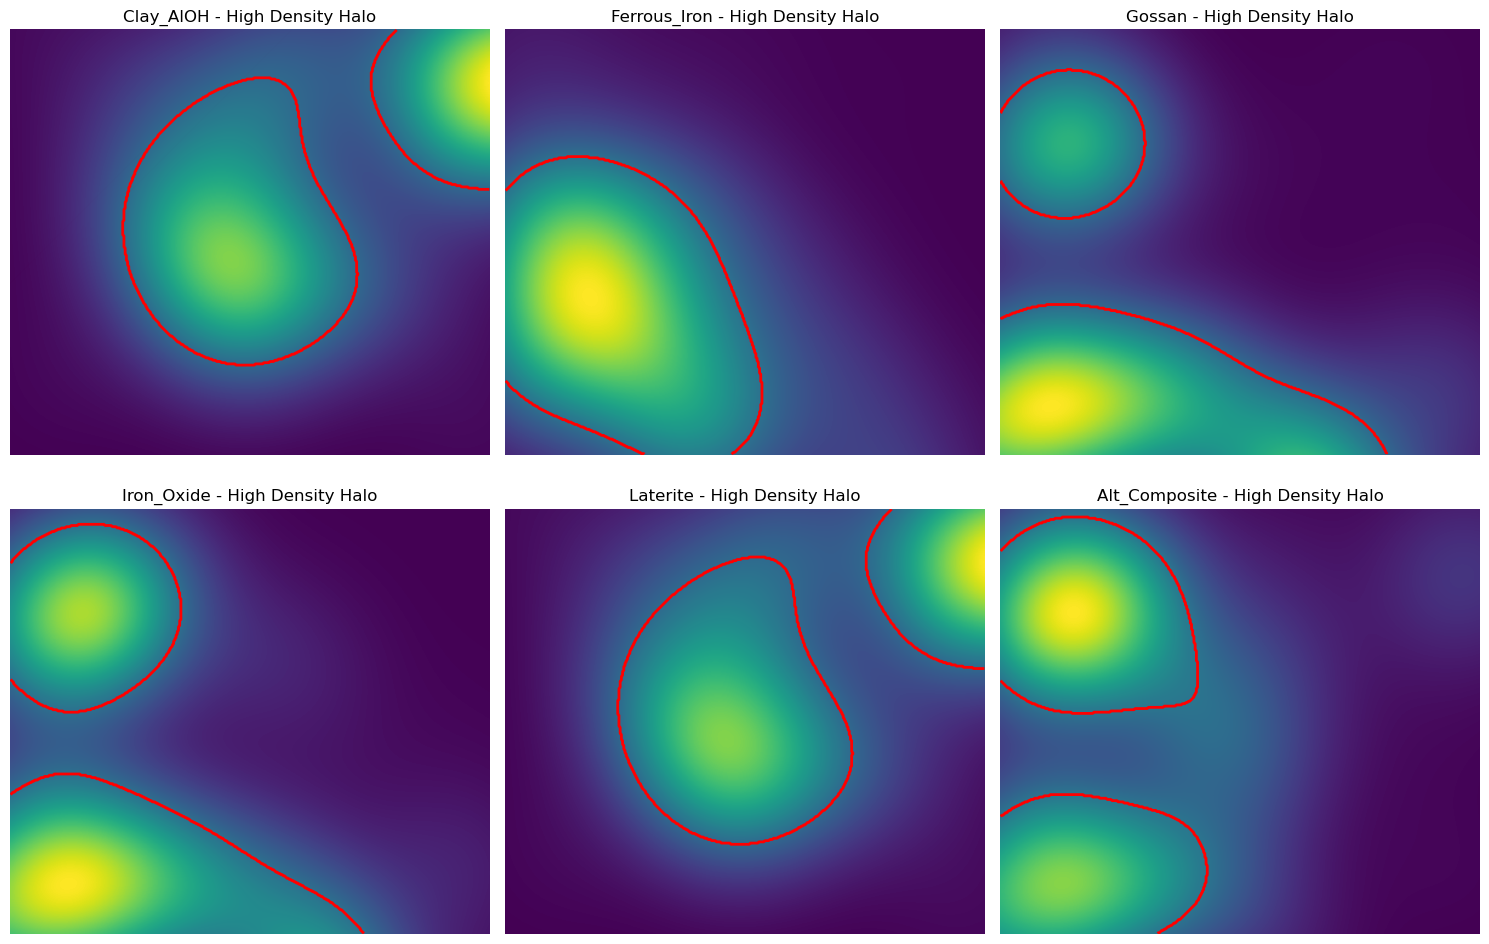

Alteration type classes:
0: Background
1: Advanced Argillic (5039 pixels, 3.6%)
2: Phyllic (18365 pixels, 13.2%)
3: Argillic (12389 pixels, 8.9%)
4: Propylitic (28326 pixels, 20.4%)
5: Gossan (12242 pixels, 8.8%)
6: Laterite (33643 pixels, 24.2%)


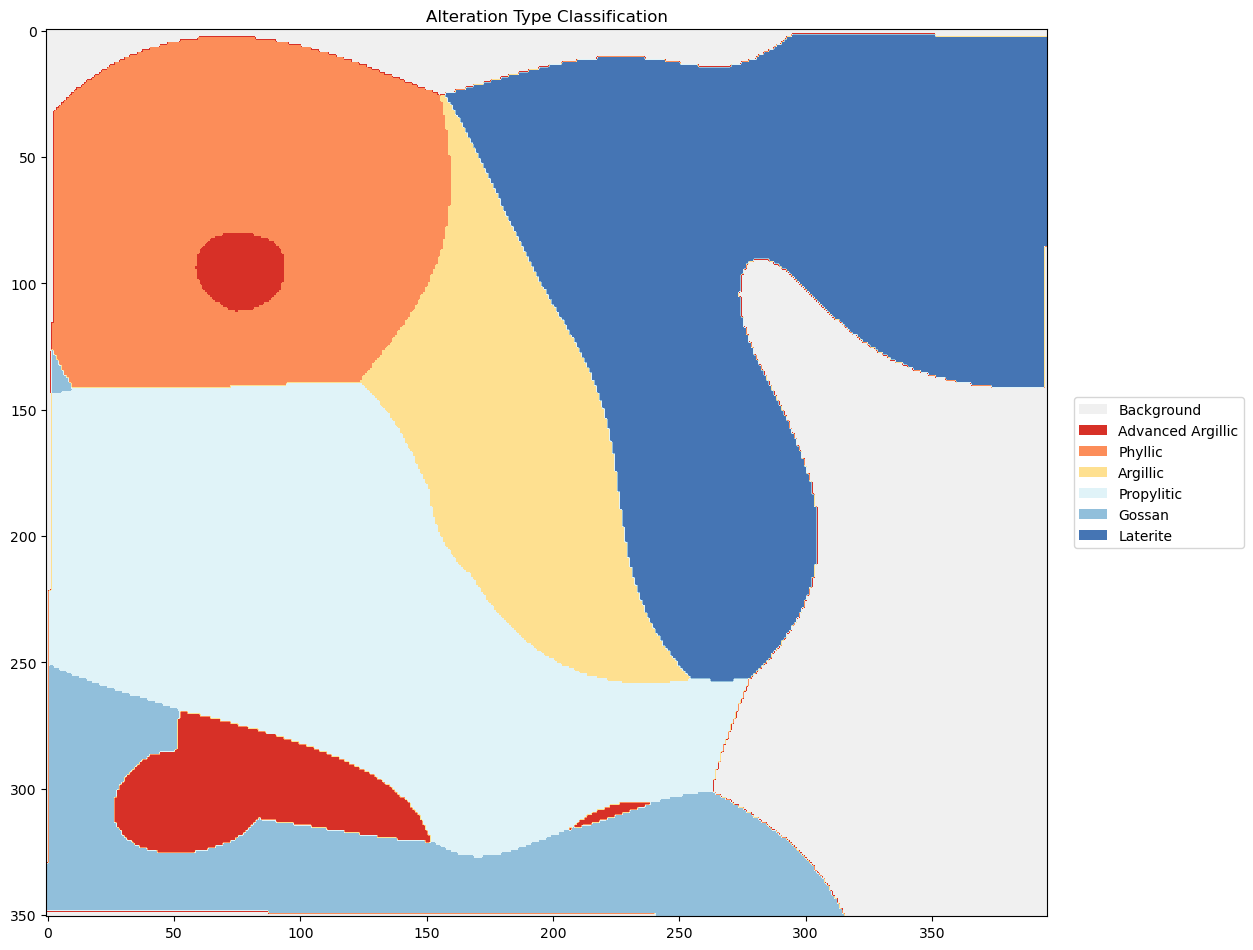


SPECTRAL HALO CLASSIFICATION:
-----------------------------
This unsupervised approach identifies alteration types based on:
1. Spectral index values (proxy for mineralogy)
2. Spatial density patterns (KDE)
3. Weighted combinations based on expected assemblages

Validation should include:
- Field verification of predicted alteration types
- Comparison with known mineralization
- Cross-validation with other datasets (geochemistry, geophysics)



In [8]:
# Load spectral indices from user-provided directory
spectral_dir = require_path(DATA_CONFIG['spectral_indices_dir'], 'spectral_indices_dir', allow_dir=True)

spectral_indices = {}
spectral_extent = None
for tif_path in sorted(spectral_dir.glob('*.tif')):
    data, extent, _ = h.load_raster(tif_path)
    data = np.array(data, dtype=float)
    data[~np.isfinite(data)] = np.nan
    spectral_indices[tif_path.stem] = data
    if spectral_extent is None:
        spectral_extent = extent

if not spectral_indices:
    raise ValueError(f"No GeoTIFFs found in {spectral_dir}")

spectral_indices = h.map_spectral_indices(spectral_indices)

raster_shape = next(iter(spectral_indices.values())).shape
first_index = next(iter(spectral_indices.values()))
valid_mask = np.isfinite(first_index)
print(f"Loaded {len(spectral_indices)} spectral indices")

# Visualize spectral indices
n_indices = len(spectral_indices)
cols = 3
rows = int(np.ceil(n_indices / cols))
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = np.atleast_1d(axes).ravel()

for ax, (name, data) in zip(axes, spectral_indices.items()):
    h.plot_raster(data, ax=ax, title=name, cmap='viridis', robust_stretch=True)

for ax in axes[len(spectral_indices):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# Apply halo detection for each index
kde_surfaces = {}
halo_masks = {}
for name, data in spectral_indices.items():
    kde, mask = h.compute_halo_detection(
        data,
        presence_quantile=0.9,
        sigma_px=50,
        clip_q=(0.01, 0.99),
        valid_mask=valid_mask,
    )
    kde_surfaces[name] = kde
    halo_masks[name] = mask

# Visualize halo detection results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, (name, kde) in zip(axes, kde_surfaces.items()):
    ax.imshow(kde, cmap='viridis', origin='upper')
    ax.contour(halo_masks[name], levels=[0.5], colors='red', linewidths=2)
    ax.set_title(f'{name} - High Density Halo')
    ax.axis('off')

for ax in axes[len(kde_surfaces):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# Alteration type classification using weighted combination
# Weights based on typical alteration assemblages
alteration_weights = {
    'Advanced Argillic': {'Clay_AlOH': 0.4, 'Silica': 0.25, 'Iron_Oxide': 0.15, 'Alt_Composite': 0.2},
    'Phyllic': {'Clay_AlOH': 0.4, 'Iron_Oxide': 0.25, 'Silica': 0.15, 'Alt_Composite': 0.2},
    'Argillic': {'Clay_AlOH': 0.4, 'Silica': 0.2, 'Laterite': 0.2, 'Alt_Composite': 0.2},
    'Propylitic': {'Ferrous_Iron': 0.4, 'Clay_AlOH': 0.2, 'Laterite': 0.2, 'Silica': 0.2},
    'Gossan': {'Iron_Oxide': 0.35, 'Gossan': 0.35, 'Silica': 0.15, 'Alt_Composite': 0.15},
    'Laterite': {'Laterite': 0.6, 'Iron_Oxide': 0.2, 'Clay_AlOH': 0.2},
}
# Normalize all KDE surfaces
kde_normalized = {name: h.normalize_kde(kde) for name, kde in kde_surfaces.items()}

# Compute weighted scores for each alteration type
alteration_scores = {}
valid_classes = []
for alt_type, weights in alteration_weights.items():
    score = np.zeros(raster_shape)
    used = 0
    for index_name, weight in weights.items():
        if index_name in kde_normalized:
            score += weight * kde_normalized[index_name]
            used += 1
    if used > 0:
        alteration_scores[alt_type] = h.normalize_kde(score)
        valid_classes.append(alt_type)

if not valid_classes:
    raise ValueError('No matching spectral indices found for alteration weights.')

# Classify based on highest score
all_scores = np.stack([alteration_scores[k] for k in valid_classes], axis=-1)
class_map = np.argmax(all_scores, axis=-1) + 1

# Mask low-confidence areas
max_scores = np.max(all_scores, axis=-1)
finite_mask = np.isfinite(max_scores)
if np.any(finite_mask):
    confidence_threshold = np.nanpercentile(max_scores[finite_mask], 20)
else:
    confidence_threshold = 0

class_map[max_scores < confidence_threshold] = 0
if "valid_mask" in locals():
    class_map[~valid_mask] = 0

print("Alteration type classes:")
print("0: Background")
for i, name in enumerate(valid_classes, 1):
    count = (class_map == i).sum()
    print(f"{i}: {name} ({count} pixels, {count / class_map.size * 100:.1f}%)")

# Visualize alteration classification
class_names = ['Background'] + valid_classes
fig, ax = h.plot_alteration_map(class_map, class_names=class_names, figsize=(12, 10))
plt.show()

print("""
SPECTRAL HALO CLASSIFICATION:
-----------------------------
This unsupervised approach identifies alteration types based on:
1. Spectral index values (proxy for mineralogy)
2. Spatial density patterns (KDE)
3. Weighted combinations based on expected assemblages

Validation should include:
- Field verification of predicted alteration types
- Comparison with known mineralization
- Cross-validation with other datasets (geochemistry, geophysics)
""")


### Supervised ML Prospectivity Mapping

See full reference implementation in `supervised_ML/`.


In [9]:
# Feature stack from user-provided rasters
feature_stack = []
prospect_extent = None

if DATA_CONFIG['prospectivity_feature_rasters']:
    for path in DATA_CONFIG['prospectivity_feature_rasters']:
        data, extent, _ = h.load_raster(path)
        feature_stack.append(data)
        if prospect_extent is None:
            prospect_extent = extent

if DATA_CONFIG['geophysics_dir']:
    dir_path = require_path(DATA_CONFIG['geophysics_dir'], 'geophysics_dir', allow_dir=True)
    for path in sorted(dir_path.glob('*.tif')):
        data, extent, _ = h.load_raster(path)
        feature_stack.append(data)
        if prospect_extent is None:
            prospect_extent = extent

if not feature_stack:
    raise ValueError('Provide prospectivity_feature_rasters and/or geophysics_dir to build a feature stack.')

feature_stack = np.stack(feature_stack, axis=-1)
rows, cols, n_features = feature_stack.shape

# Training data
train_path = require_path(DATA_CONFIG['prospectivity_training_points_path'], 'prospectivity_training_points_path')
train_gdf = h.load_vector(train_path)
label_candidates = [c for c in train_gdf.columns if c.lower() in ['label', 'target', 'prospectivity']]
if not label_candidates:
    raise ValueError('Training points file must include a label column like label/target/prospectivity.')
label_col = label_candidates[0]

train_gdf = h.ensure_xy(train_gdf)
xmin, xmax, ymin, ymax = prospect_extent

col_idx = ((train_gdf['X'] - xmin) / (xmax - xmin) * (cols - 1)).astype(int)
row_idx = ((ymax - train_gdf['Y']) / (ymax - ymin) * (rows - 1)).astype(int)
valid = (col_idx >= 0) & (col_idx < cols) & (row_idx >= 0) & (row_idx < rows)

X = feature_stack[row_idx[valid], col_idx[valid], :]
y = train_gdf.loc[valid, label_col].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict prospectivity across the grid
flat_features = feature_stack.reshape(-1, n_features)
prob = rf.predict_proba(flat_features)[:, 1].reshape(rows, cols)

h.plot_prospectivity_map(prob, extent=prospect_extent, threshold=0.6)
plt.show()

# Evaluate
from sklearn.metrics import classification_report
print(classification_report(y_test, rf.predict(X_test)))


ValueError: Missing required path for prospectivity_training_points_path.